In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn .metrics import mean_absolute_error,mean_squared_error

# Load cleaned data
df = pd.read_csv('../data/cleaned_superstore.csv')
df['order_date'] = pd.to_datetime(df['order_date'])
df.head()


d:\Retail_Sales_Forecasting\retail\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,category,sub-category,product_name,sales,quantity,discount,profit,year,sales_per_quantity,month
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,130.9800,11
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,243.9800,11
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,7.3100,6
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,191.5155,10
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,11.1840,10


In [2]:
daily_sales = df.groupby('order_date')['sales'].sum().reset_index()
daily_sales.head()


,order_date,sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


In [3]:
data = daily_sales.rename(columns={'order_date': 'ds', 'sales': 'y'})
data.head()


,ds,y
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


In [4]:
train=data.iloc[:-90]
test=data.iloc[-90:]


In [5]:
model=Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)
model.fit(train)

14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
future=model.make_future_dataframe(periods=90)
future.tail()

,ds
1232,2017-12-21
1233,2017-12-22
1234,2017-12-23
1235,2017-12-24
1236,2017-12-25


In [7]:
forecast=model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1232,2017-12-21,3447.862832,805.279937,6200.140877
1233,2017-12-22,3595.152626,1051.920046,6353.490304
1234,2017-12-23,3201.531831,571.841671,5961.351173
1235,2017-12-24,3263.512028,512.873268,5955.176563
1236,2017-12-25,3423.191673,796.032814,6025.340866


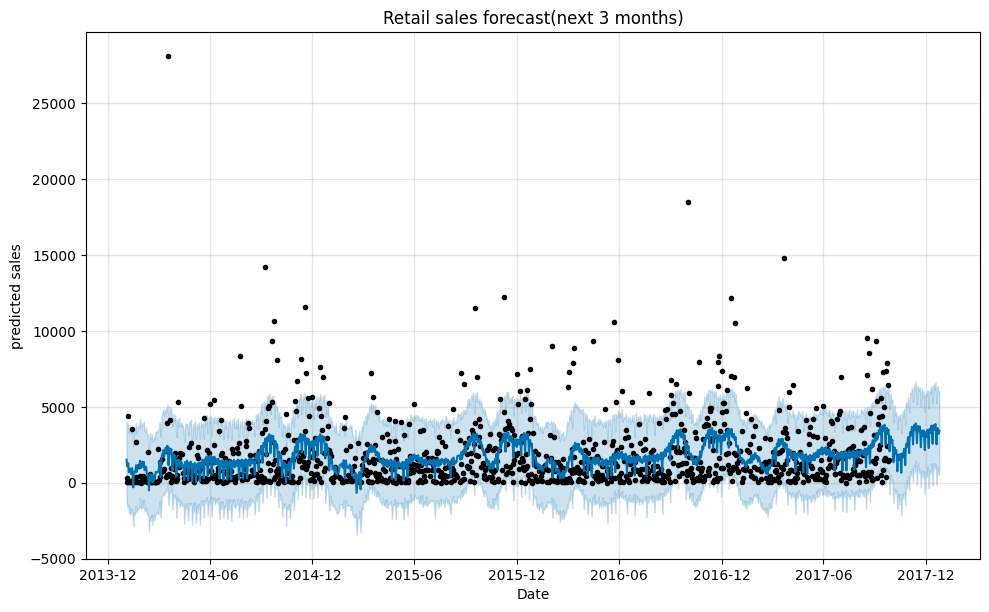

In [8]:
fig1=model.plot(forecast)
plt.title("Retail sales forecast(next 3 months)")
plt.xlabel("Date")
plt.ylabel("predicted sales")
plt.show()


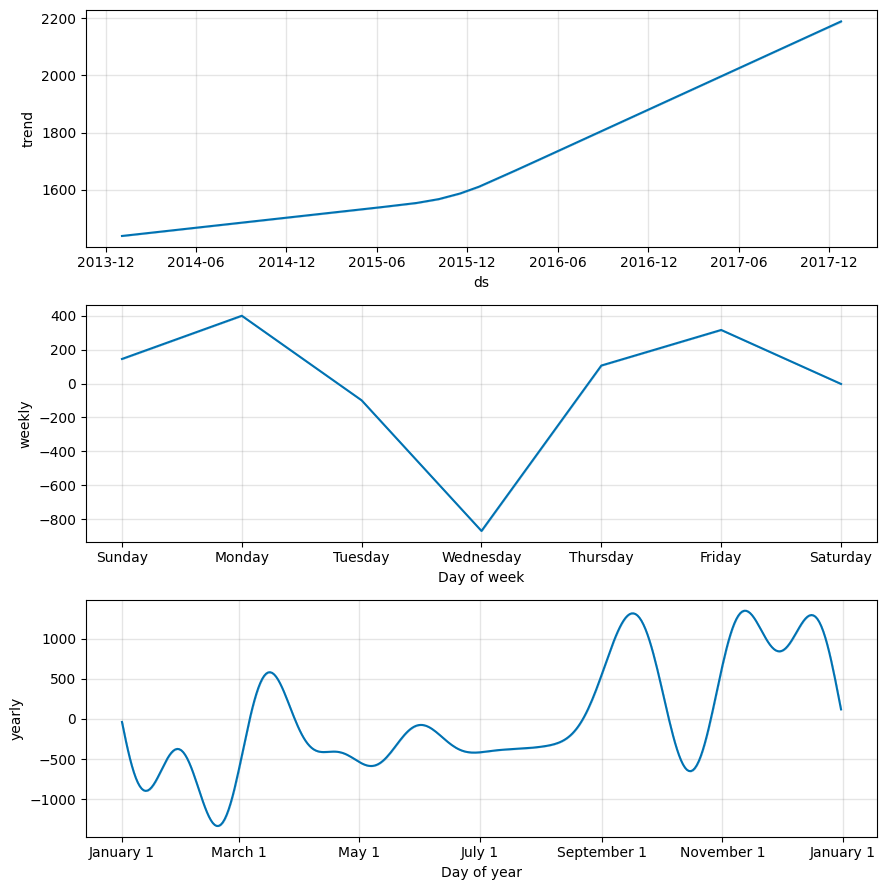

In [9]:
fig2=model.plot_components(forecast)
plt.show()

In [14]:
# Ensure date columns are in datetime format
forecast['ds'] = pd.to_datetime(forecast['ds'])
test['ds'] = pd.to_datetime(test['ds'])

# Merge on date safely
merged = pd.merge(test, forecast[['ds', 'yhat']], on='ds', how='inner')

# Check if merging worked correctly
print("Rows in test:", len(test))
print("Rows in merged:", len(merged))
merged.head()


Rows in test: 90
Rows in merged: 85


C:\Users\sanja\AppData\Local\Temp\ipykernel_22504\1298957124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


,ds,y,yhat
0,2017-09-28,559.271,2942.485182
1,2017-09-29,1944.080,3054.568280
2,2017-09-30,540.760,2633.433611
3,2017-10-01,2978.466,2676.091107
4,2017-10-02,5418.022,2824.968621


In [13]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(merged['y'], merged['yhat'])
print("Mean Absolute Error:", round(mae, 2))


KeyError: 'yhat'